In [1]:
import numpy as np
import math
from collections import namedtuple
from scipy.stats import poisson
import copy
import os
import sys
import timeit
import time
import pandas as pd

### First ever RL practice, from http://www.incompleteideas.net/book/ebook/node43.html, Example 4.2 Jack's Car Rental
Takes only a few minutes to run, since the bulk of the calculation is independent of state value and policy, I calculated them once first before using them.  
Final policy graph seems a little different from the authors' but I am not sure what they meant by 'a small positive number' nor do I want to spend more time on this exercise.   
Spent alot of time dealing with this example already.. back to studying  
Note to self also, I used pandas dataframe here because the previous attempt at purely using numpy array turned into some excessive numpy broadcasting exercise, dataframe is alot easier on the eyes in jupyter, makes it easier to test and verify things as well  
To use with any policy that distributes probabilities across the actionspace instead of only taking a single action with probability 100%, just need to modify/add a few lines under policy_evaluation and policy_improvement.  
This script takes about 2.5mins to run on i7-9700K. Way faster than the previous abomination...

In [2]:
#SET GLOBAL VARIABLES HERE, AS GIVEN IN THE EXERCISE

#values for poisson distrib
LOC1_RENTAL = 3
LOC1_RETURN = 3
LOC2_RENTAL = 4
LOC2_RETURN = 2

MAXCARS = 20
MINCARS = 0
MOVECARSMAX = 5 #negative is defined here as loc1 moving cars to loc2

MOVECARCOST= 2

DISCOUNT = 0.9
RENTREWARD = 10

In [3]:
start_time = time.time()

In [4]:
#The dictionary value is obsolete here, just using this dictionary for the keys.
#This thing is just taken from my previous attempt at this example

State = namedtuple('State',('loc1','loc2'))
VS ={}

for loc1 in range(0,21): #there are 21 valid values in this question, 0 to 20 cars for each location
    for loc2 in range(0,21):
        VS[State(loc1,loc2)] = 0

In [5]:
df = pd.DataFrame(data = list(VS.keys()))
df['StateValue'] = 0

Movement is negative from loc1-> loc2, positive from loc2->loc1

Car moving is allowed as long as original location doesn't go lower then 0

In [6]:
movingoptions = list(range(-MOVECARSMAX,MOVECARSMAX+1))

def get_actionspace(dfrow):
    actions = movingoptions.copy()
    actions[:] = [option for option in actions if MINCARS<=option + dfrow.loc1]
    actions[:] = [option for option in actions if MINCARS<= (-1 * option) + dfrow.loc2] # -1*value because this checks valid loc2->loc1
    
    return actions

df['moveactions'] = df.apply(lambda row :get_actionspace(row),axis=1)

In [7]:
df.head()

,loc1,loc2,StateValue,moveactions
0,0,0,0,[0]
1,0,1,0,"[0, 1]"
2,0,2,0,"[0, 1, 2]"
3,0,3,0,"[0, 1, 2, 3]"
4,0,4,0,"[0, 1, 2, 3, 4]"


Generate probabilities of moveactions, set starting policy with action==0 @ probability of 100% (policy of not moving at all)
This row might be used for later for some math operation, so setting type as np array

In [8]:
def set_startprobability(dfrow):
    arrayz = np.zeros(len(dfrow.moveactions))
    arrayz[dfrow.moveactions.index(0)] = 1
    return arrayz

df['action_probs'] = df.apply(lambda row: set_startprobability(row)   ,axis=1)

In [9]:
df.head()

,loc1,loc2,StateValue,moveactions,action_probs
0,0,0,0,[0],[1.0]
1,0,1,0,"[0, 1]","[1.0, 0.0]"
2,0,2,0,"[0, 1, 2]","[1.0, 0.0, 0.0]"
3,0,3,0,"[0, 1, 2, 3]","[1.0, 0.0, 0.0, 0.0]"
4,0,4,0,"[0, 1, 2, 3, 4]","[1.0, 0.0, 0.0, 0.0, 0.0]"


every action will lead to an intermediate state as it directly modifies loc1,loc2 in a constant manner

In [10]:
def bound_number(loc_count):
    if loc_count> MAXCARS:
        return MAXCARS
    elif loc_count <MINCARS:
        return MINCARS
    else:
        return loc_count

def get_intermediate_state(dfrow):
    intermediate_states=[]
    actions = dfrow.moveactions
    for action in actions:
        intermediate_states.append(State(bound_number(dfrow.loc1+action),bound_number(dfrow.loc2-action)))
    return intermediate_states

df['itmd_states'] = df.apply(lambda row: get_intermediate_state(row),axis=1)

In [11]:
df.head()

,loc1,loc2,StateValue,moveactions,action_probs,itmd_states
0,0,0,0,[0],[1.0],"[(0, 0)]"
1,0,1,0,"[0, 1]","[1.0, 0.0]","[(0, 1), (1, 0)]"
2,0,2,0,"[0, 1, 2]","[1.0, 0.0, 0.0]","[(0, 2), (1, 1), (2, 0)]"
3,0,3,0,"[0, 1, 2, 3]","[1.0, 0.0, 0.0, 0.0]","[(0, 3), (1, 2), (2, 1), (3, 0)]"
4,0,4,0,"[0, 1, 2, 3, 4]","[1.0, 0.0, 0.0, 0.0, 0.0]","[(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]"


Actions are chosen by policy, dependent on State Value function but for each action, its effect on the startstate is constant  
From every intermediate state, the transition probability and rewards to all 441 possible endstates are constant of policy/state value function  
So, from now, calculate all the things needed from intermediate -> 441 endstates

Construct loc1 tables, for all intermediate loc1 transition possibility to all final loc1s.  
Column headers are the endstate loc1 values  
Indexes are the intermediate loc1 values

## Note that the returns can go to an infinite sequence when endstate is 20 at either locations, since any excess returns just magically disappear
## The poisson means for returns are 3 and 2 for locs 1 and 2. Any values from ~>15 for both distributions are already at insignificant values, thus not including these >20 returns

In [12]:
loc1df = pd.DataFrame(data=np.zeros((MAXCARS+1,MAXCARS+1)),columns =[['EndState']*(MAXCARS+1),list(range(0,MAXCARS+1))],dtype=object)

In [13]:
loc1df.head()

EndState                            ...                              
        0  1  2  3  4  5  6  7  8  9  ... 11 12 13 14 15 16 17 18 19 20
0        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
1        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
2        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
3        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0
4        0  0  0  0  0  0  0  0  0  0 ...  0  0  0  0  0  0  0  0  0  0

[5 rows x 21 columns]

In [14]:
def loc1df_probgen(start,end): #1 start loc to all 21 endloc
    
    #start - rent + return = end
    #neither start nor end is allowed to go below 0
    #maximum
    if start < end:
        rentrange = np.array(range(start+1))
        returnrange = np.flip(end - rentrange)
        
    elif start > end:
        returnrange = np.array(range(end+1))
        rentrange = np.flip(start-returnrange)
    
    elif start == end:
        returnrange = np.array(range(end+1))
        rentrange = np.array(range(end+1))
        
    rentprob = poisson.pmf(rentrange,LOC1_RENTAL)
    returnprob = poisson.pmf(returnrange,LOC1_RETURN)
    
    #totalprob = (rentprob*returnprob).sum()
              
    return rentprob*returnprob

In [15]:
for row in range(loc1df.shape[0]):#columns are endstates!
    for column in range(loc1df.shape[1]):
        loc1df.iloc[row][column] = loc1df_probgen(row,column)

In [16]:
loc1df.head()

EndState                                                 \
                        0                                              1    
0  [0.0024787521766663585]                         [0.007436256529999076]   
1   [0.007436256529999076]  [0.0024787521766663585, 0.022308769589997234]   
2   [0.011154384794998614]    [0.007436256529999076, 0.03346315438499584]   
3   [0.011154384794998614]    [0.011154384794998614, 0.03346315438499584]   
4   [0.008365788596248962]    [0.011154384794998614, 0.02509736578874689]   

                                                      \
                                                  2    
0                             [0.011154384794998614]   
1        [0.007436256529999076, 0.03346315438499584]   
2  [0.0024787521766663585, 0.022308769589997234, ...   
3  [0.007436256529999076, 0.03346315438499584, 0....   
4  [0.011154384794998614, 0.03346315438499584, 0....   

                                                      \
                                                  3    
0                             [0.011154384794998614]   
1        [0.011154384794998614, 0.03346315438499584]   
2  [0.007436256529999076, 0.03346315438499584, 0....   
3  [0.0024787521766663585, 0.022308769589997234, ...   
4  [0.007436256529999076, 0.03346315438499584, 0....   

                                                      \
                                                  4    
0                             [0.008365788596248962]   
1        [0.011154384794998614, 0.02509736578874689]   
2  [0.011154384794998614, 0.03346315438499584, 0....   
3  [0.007436256529999076, 0.03346315438499584, 0....   
4  [0.0024787521766663585, 0.022308769589997234, ...   

                                                      \
                                                  5    
0                              [0.00501947315774938]   
1       [0.008365788596248962, 0.015058419473248144]   
2  [0.011154384794998614, 0.02509736578874689, 0....   
3  [0.011154384794998614, 0.03346315438499584, 0....   
4  [0.007436256529999076, 0.03346315438499584, 0....   

                                                      \
                                                  6    
0                             [0.002509736578874688]   
1        [0.00501947315774938, 0.007529209736624065]   
2  [0.008365788596248962, 0.015058419473248144, 0...   
3  [0.011154384794998614, 0.02509736578874689, 0....   
4  [0.011154384794998614, 0.03346315438499584, 0....   

                                                      \
                                                  7    
0                             [0.001075601390946295]   
1      [0.002509736578874688, 0.0032268041728388853]   
2  [0.00501947315774938, 0.007529209736624065, 0....   
3  [0.008365788596248962, 0.015058419473248144, 0...   
4  [0.011154384794998614, 0.02509736578874689, 0....   

                                                      \
                                                  8    
0                            [0.0004033505216048606]   
1       [0.001075601390946295, 0.001210051564814582]   
2  [0.002509736578874688, 0.0032268041728388853, ...   
3  [0.00501947315774938, 0.007529209736624065, 0....   
4  [0.008365788596248962, 0.015058419473248144, 0...   

                                                      \
                                                  9    
0                           [0.00013445017386828694]   
1     [0.0004033505216048606, 0.0004033505216048609]   
2  [0.001075601390946295, 0.001210051564814582, 0...   
3  [0.002509736578874688, 0.0032268041728388853, ...   
4  [0.00501947315774938, 0.007529209736624065, 0....   

                         ...                          \
                         ...                           
0                        ...                           
1                        ...                           
2                        ...                           
3                        ...                          

Now generate the same probability table for loc2

In [17]:
def loc2df_probgen(start,end): #1 start loc to all 21 endloc
    
    #start - rent + return = end
    #neither start nor end is allowed to go below 0
    #maximum
    if start < end:
        rentrange = np.array(range(start+1))
        returnrange = np.flip(end - rentrange)
        
    elif start > end:
        returnrange = np.array(range(end+1))
        rentrange = np.flip(start-returnrange)
    
    elif start == end:
        returnrange = np.array(range(end+1))
        rentrange = np.array(range(end+1))
        
     
    rentprob = poisson.pmf(rentrange,LOC2_RENTAL)
    returnprob = poisson.pmf(returnrange,LOC2_RETURN)
    
  #  totalprob = (rentprob*returnprob).sum()
              
    return rentprob*returnprob

In [18]:
loc2df = pd.DataFrame(data=np.zeros((MAXCARS+1,MAXCARS+1)),columns =[['EndState']*(MAXCARS+1),list(range(0,MAXCARS+1))],dtype=object)

In [19]:
for row in range(loc2df.shape[0]):#columns are endstates!
    for column in range(loc2df.shape[1]):
        loc2df.iloc[row][column] = loc2df_probgen(row,column)

In [20]:
loc2df.head()

EndState                                                \
                        0                                             1    
0  [0.0024787521766663585]                        [0.004957504353332717]   
1   [0.009915008706665436]  [0.0024787521766663585, 0.01983001741333087]   
2   [0.019830017413330868]  [0.009915008706665436, 0.039660034826661736]   
3   [0.026440023217774486]   [0.019830017413330868, 0.05288004643554897]   
4   [0.026440023217774486]   [0.026440023217774486, 0.05288004643554897]   

                                                      \
                                                  2    
0                             [0.004957504353332717]   
1        [0.004957504353332717, 0.01983001741333087]   
2  [0.0024787521766663585, 0.01983001741333087, 0...   
3  [0.009915008706665436, 0.039660034826661736, 0...   
4  [0.019830017413330868, 0.05288004643554897, 0....   

                                                      \
                                                  3    
0                            [0.0033050029022218103]   
1       [0.004957504353332717, 0.013220011608887245]   
2  [0.004957504353332717, 0.01983001741333087, 0....   
3  [0.0024787521766663585, 0.01983001741333087, 0...   
4  [0.009915008706665436, 0.039660034826661736, 0...   

                                                      \
                                                  4    
0                            [0.0016525014511109052]   
1      [0.0033050029022218103, 0.006610005804443622]   
2  [0.004957504353332717, 0.013220011608887245, 0...   
3  [0.004957504353332717, 0.01983001741333087, 0....   
4  [0.0024787521766663585, 0.01983001741333087, 0...   

                                                      \
                                                  5    
0                            [0.0006610005804443623]   
1     [0.0016525014511109052, 0.0026440023217774496]   
2  [0.0033050029022218103, 0.006610005804443622, ...   
3  [0.004957504353332717, 0.013220011608887245, 0...   
4  [0.004957504353332717, 0.01983001741333087, 0....   

                                                      \
                                                  6    
0                           [0.00022033352681478726]   
1     [0.0006610005804443623, 0.0008813341072591492]   
2  [0.0016525014511109052, 0.0026440023217774496,...   
3  [0.0033050029022218103, 0.006610005804443622, ...   
4  [0.004957504353332717, 0.013220011608887245, 0...   

                                                      \
                                                  7    
0                            [6.295243623279636e-05]   
1    [0.00022033352681478726, 0.0002518097449311855]   
2  [0.0006610005804443623, 0.0008813341072591492,...   
3  [0.0016525014511109052, 0.0026440023217774496,...   
4  [0.0033050029022218103, 0.006610005804443622, ...   

                                                      \
                                                  8    
0                           [1.5738109058199087e-05]   
1     [6.295243623279636e-05, 6.295243623279636e-05]   
2  [0.00022033352681478726, 0.0002518097449311855...   
3  [0.0006610005804443623, 0.0008813341072591492,...   
4  [0.0016525014511109052, 0.0026440023217774496,...   

                                                      \
                                                  9    
0                           [3.4973575684886935e-06]   
1   [1.5738109058199087e-05, 1.3989430273954776e-05]   
2  [6.295243623279636e-05, 6.295243623279636e-05,...   
3  [0.00022033352681478726, 0.0002518097449311855...   
4  [0.0006610005804443623, 0.0008813341072591492,...   

                         ...                          \
                         ...                           
0                        ...                           
1                        ...                           
2                        ...                           
3                        ...                           
4    

### loc1 and loc2 probabilities done. 
### now assemble both tables into one, for all intermediate states to all respective 441 final states

loc1 is built to contain every possible transition probablility to each end state, since every such transition can pair with each possible transition to endstate at loc2

e.g  
  
(2,2) -> (20,20)

loc1                |loc2   |
:--------------------|--------------------|
rent 2 return 20   |   rent 2, return 20  | 
                   |   rent 1  return 19  |
                   |   rent 0  return 18  |
rent 1  return 19   |  rent 2 return 20  |
                    |  rent 1 return 19  |
                    |  rent 0 return 18  |                                  
rent 0  return 18   |  rent 2 return 20  |
                    |  rent 1 return 19  |
                    |  rent 0 return 18  |

In [21]:
finalstatescount = (MAXCARS+1)*(MAXCARS+1)
finalprobdf = pd.DataFrame(data=np.zeros(((finalstatescount,finalstatescount))),columns=[['EndState']*finalstatescount,list(VS.keys())],dtype=object)
finalprobdf.index = list(VS.keys())

In [22]:
finalprobdf.head()

EndState                                                          \
         (0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) (0, 6) (0, 7) (0, 8)   
(0, 0)        0      0      0      0      0      0      0      0      0   
(0, 1)        0      0      0      0      0      0      0      0      0   
(0, 2)        0      0      0      0      0      0      0      0      0   
(0, 3)        0      0      0      0      0      0      0      0      0   
(0, 4)        0      0      0      0      0      0      0      0      0   

                ...                                                           \
       (0, 9)   ...    (20, 11) (20, 12) (20, 13) (20, 14) (20, 15) (20, 16)   
(0, 0)      0   ...           0        0        0        0        0        0   
(0, 1)      0   ...           0        0        0        0        0        0   
(0, 2)      0   ...           0        0        0        0        0        0   
(0, 3)      0   ...           0        0        0        0        0        0   
(0, 4)      0   ...           0        0        0        0        0        0   

                                            
       (20, 17) (20, 18) (20, 19) (20, 20)  
(0, 0)        0        0        0        0  
(0, 1)        0        0        0        0  
(0, 2)        0        0        0        0  
(0, 3)        0        0        0        0  
(0, 4)        0        0        0        0  

[5 rows x 441 columns]

In [23]:
#got the startstate and endstate, assemble total probability
for rownumber in range(len(finalprobdf)):
    startstaterow = finalprobdf.iloc[rownumber]
    startstate = startstaterow.name
    for columnnumber in range(len(finalprobdf)):
        endstate = finalprobdf.columns[columnnumber][1]
        location1probs = loc1df.iloc[startstate[0]][endstate.loc1]
        location2probs = loc2df.iloc[startstate[1]][endstate.loc2]

        finalprobs = location1probs.reshape(-1,1)*location2probs
        finalprobdf.iloc[rownumber][columnnumber] = finalprobs

        #got the startstate and endstate, assemble total probability
        
        
        
        

normalize the probabilities for each row to 1  
These probabilities are conditional probabilities given an action

In [24]:
for row in range(len(finalprobdf)):
    finalprobdf.iloc[row] = finalprobdf.iloc[row]/finalprobdf.iloc[row].apply(np.sum).sum()

In [25]:
finalprobdf.head()

EndState  \
                          (0, 0)   
(0, 0)   [[0.00673794699916495]]   
(0, 1)  [[0.005390357599332023]]   
(0, 2)  [[0.004146428922563326]]   
(0, 3)  [[0.003036821182723414]]   
(0, 4)  [[0.002093342757027397]]   

                                                         \
                                                 (0, 1)   
(0, 0)                           [[0.0134758939983299]]   
(0, 1)  [[0.0013475893998330054, 0.010780715198664047]]   
(0, 2)  [[0.0020732144612816633, 0.008292857845126652]]   
(0, 3)  [[0.0022776158870425607, 0.006073642365446828]]   
(0, 4)   [[0.002093342757027397, 0.004186685514054794]]   

                                                           \
                                                   (0, 2)   
(0, 0)                             [[0.0134758939983299]]   
(0, 1)     [[0.002695178799666011, 0.010780715198664047]]   
(0, 2)  [[0.0005183036153204157, 0.004146428922563327,...   
(0, 3)  [[0.0011388079435212808, 0.004555231774085121,...   
(0, 4)  [[0.001570007067770548, 0.004186685514054794, ...   

                                                           \
                                                   (0, 3)   
(0, 0)                            [[0.00898392933221993]]   
(0, 1)      [[0.002695178799666011, 0.00718714346577603]]   
(0, 2)  [[0.0010366072306408315, 0.004146428922563327,...   
(0, 3)  [[0.0002847019858803201, 0.0022776158870425616...   
(0, 4)  [[0.0007850035338852743, 0.003140014135541096,...   

                                                           \
                                                   (0, 4)   
(0, 0)                           [[0.004491964666109965]]   
(0, 1)    [[0.0017967858664440066, 0.003593571732888015]]   
(0, 2)  [[0.0010366072306408315, 0.0027642859483755504...   
(0, 3)  [[0.0005694039717606402, 0.0022776158870425616...   
(0, 4)  [[0.0001962508834713185, 0.0015700070677705485...   

                                                           \
                                                   (0, 5)   
(0, 0)                           [[0.001796785866443987]]   
(0, 1)   [[0.0008983929332220033, 0.0014374286931552061]]   
(0, 2)  [[0.0006910714870938874, 0.0013821429741877752...   
(0, 3)  [[0.0005694039717606402, 0.0015184105913617072...   
(0, 4)  [[0.000392501766942637, 0.0015700070677705485,...   

                                                           \
                                                   (0, 6)   
(0, 0)                          [[0.0005989286221479952]]   
(0, 1)   [[0.0003593571732888015, 0.0004791428977184017]]   
(0, 2)  [[0.0003455357435469437, 0.0005528571896751102...   
(0, 3)  [[0.0003796026478404267, 0.0007592052956808536...   
(0, 4)  [[0.000392501766942637, 0.0010466713785136988,...   

                                                           \
                                                   (0, 7)   
(0, 0)                         [[0.00017112246347085578]]   
(0, 1)  [[0.00011978572442960042, 0.0001368979707766862]]   
(0, 2)  [[0.00013821429741877754, 0.000184285729891703...   
(0, 3)  [[0.00018980132392021335, 0.000303682118272341...   
(0, 4)  [[0.0002616678446284246, 0.0005233356892568494...   

                                                           \
                                                   (0, 8)   
(0, 0)                          [[4.278061586771393e-05]]   
(0, 1)   [[3.422449269417155e-05, 3.422449269417155e-05]]   
(0, 2)  [[4.607143247292581e-05, 5.265306568334379e-05...   
(0, 3)  [[7.592052956808537e-05, 0.0001012273727574470...   
(0, 4)  [[0.0001308339223142123, 0.0002093342757027397...   

                                                           \
                                                   (0, 9)   
(0, 0)                          [[9.506803526158673e-06]]   
(0, 1)   [[8.556123173542884e-06, 7.605442820927026e-06]]   
(0, 2)  [[1.3163266420835947e-05, 1.3163266420835947e-...   
(0, 3)  [[2.530684318936177e-05, 2.8922106502127743e-0..

### Build the rewards table now
Can reuse most of the code from probability tables above, supposed to give the same kind of table anyway

In [26]:
def df_rentgen(start,end): #rentgen doesnt care which loc it is
    
    #start - rent + return = end
    #neither start nor end is allowed to go below 0
    #maximum
    if start < end:
        rentrange = np.array(range(start+1))
        returnrange = np.flip(end - rentrange)
        
    elif start > end:
        returnrange = np.array(range(end+1))
        rentrange = np.flip(start-returnrange)
    
    elif start == end:
        returnrange = np.array(range(end+1))
        rentrange = np.array(range(end+1))

    
    #totalprob = (rentprob*returnprob).sum()
              
    return rentrange

In [27]:
loc1rentdf = pd.DataFrame(data=np.zeros((MAXCARS+1,MAXCARS+1)),columns =[['EndState']*(MAXCARS+1),list(range(0,MAXCARS+1))],dtype=object)
loc2rentdf = pd.DataFrame(data=np.zeros((MAXCARS+1,MAXCARS+1)),columns =[['EndState']*(MAXCARS+1),list(range(0,MAXCARS+1))],dtype=object)

In [28]:
for row in range(loc1rentdf.shape[0]):#columns are endstates!
    for column in range(loc1rentdf.shape[1]):
        loc1rentdf.iloc[row][column] = df_rentgen(row,column)

In [29]:
for row in range(loc2rentdf.shape[0]):#columns are endstates!
    for column in range(loc2rentdf.shape[1]):
        loc2rentdf.iloc[row][column] = df_rentgen(row,column)

In [30]:
finalstatescount = (MAXCARS+1)*(MAXCARS+1)
finalrentdf = pd.DataFrame(data=np.zeros(((finalstatescount,finalstatescount))),columns=[['EndState']*finalstatescount,list(VS.keys())],dtype=object)
finalrentdf.index = list(VS.keys())

In [31]:
finalrentdf.head()

EndState                                                          \
         (0, 0) (0, 1) (0, 2) (0, 3) (0, 4) (0, 5) (0, 6) (0, 7) (0, 8)   
(0, 0)        0      0      0      0      0      0      0      0      0   
(0, 1)        0      0      0      0      0      0      0      0      0   
(0, 2)        0      0      0      0      0      0      0      0      0   
(0, 3)        0      0      0      0      0      0      0      0      0   
(0, 4)        0      0      0      0      0      0      0      0      0   

                ...                                                           \
       (0, 9)   ...    (20, 11) (20, 12) (20, 13) (20, 14) (20, 15) (20, 16)   
(0, 0)      0   ...           0        0        0        0        0        0   
(0, 1)      0   ...           0        0        0        0        0        0   
(0, 2)      0   ...           0        0        0        0        0        0   
(0, 3)      0   ...           0        0        0        0        0        0   
(0, 4)      0   ...           0        0        0        0        0        0   

                                            
       (20, 17) (20, 18) (20, 19) (20, 20)  
(0, 0)        0        0        0        0  
(0, 1)        0        0        0        0  
(0, 2)        0        0        0        0  
(0, 3)        0        0        0        0  
(0, 4)        0        0        0        0  

[5 rows x 441 columns]

In [32]:
for rownumber in range(len(finalrentdf)):
    startstaterow = finalrentdf.iloc[rownumber]
    startstate = startstaterow.name
    for columnnumber in range(len(finalrentdf)):
        endstate = finalrentdf.columns[columnnumber][1]
        location1rents = loc1rentdf.iloc[startstate[0]][endstate.loc1]
        location2rents = loc2rentdf.iloc[startstate[1]][endstate.loc2]

        totalrents  = location1rents.reshape(-1,1) + location2rents
        finalrentdf.iloc[rownumber][columnnumber] = totalrents


In [33]:
finalrentdf.head()

EndState                                                            \
         (0, 0)    (0, 1)       (0, 2)          (0, 3)             (0, 4)   
(0, 0)    [[0]]     [[0]]        [[0]]           [[0]]              [[0]]   
(0, 1)    [[1]]  [[0, 1]]     [[0, 1]]        [[0, 1]]           [[0, 1]]   
(0, 2)    [[2]]  [[1, 2]]  [[0, 1, 2]]     [[0, 1, 2]]        [[0, 1, 2]]   
(0, 3)    [[3]]  [[2, 3]]  [[1, 2, 3]]  [[0, 1, 2, 3]]     [[0, 1, 2, 3]]   
(0, 4)    [[4]]  [[3, 4]]  [[2, 3, 4]]  [[1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]   

                                                                 \
                   (0, 5)             (0, 6)             (0, 7)   
(0, 0)              [[0]]              [[0]]              [[0]]   
(0, 1)           [[0, 1]]           [[0, 1]]           [[0, 1]]   
(0, 2)        [[0, 1, 2]]        [[0, 1, 2]]        [[0, 1, 2]]   
(0, 3)     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]   
(0, 4)  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]   

                                                    ...          \
                   (0, 8)             (0, 9)        ...           
(0, 0)              [[0]]              [[0]]        ...           
(0, 1)           [[0, 1]]           [[0, 1]]        ...           
(0, 2)        [[0, 1, 2]]        [[0, 1, 2]]        ...           
(0, 3)     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]        ...           
(0, 4)  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]        ...           

                                                                 \
                 (20, 11)           (20, 12)           (20, 13)   
(0, 0)              [[0]]              [[0]]              [[0]]   
(0, 1)           [[0, 1]]           [[0, 1]]           [[0, 1]]   
(0, 2)        [[0, 1, 2]]        [[0, 1, 2]]        [[0, 1, 2]]   
(0, 3)     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]   
(0, 4)  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]   

                                                                 \
                 (20, 14)           (20, 15)           (20, 16)   
(0, 0)              [[0]]              [[0]]              [[0]]   
(0, 1)           [[0, 1]]           [[0, 1]]           [[0, 1]]   
(0, 2)        [[0, 1, 2]]        [[0, 1, 2]]        [[0, 1, 2]]   
(0, 3)     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]   
(0, 4)  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]   

                                                                 \
                 (20, 17)           (20, 18)           (20, 19)   
(0, 0)              [[0]]              [[0]]              [[0]]   
(0, 1)           [[0, 1]]           [[0, 1]]           [[0, 1]]   
(0, 2)        [[0, 1, 2]]        [[0, 1, 2]]        [[0, 1, 2]]   
(0, 3)     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]     [[0, 1, 2, 3]]   
(0, 4)  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]  [[0, 1, 2, 3, 4]]   

                           
                 (20, 20)  
(0, 0)              [[0]]  
(0, 1)           [[0, 1]]  
(0, 2)        [[0, 1, 2]]  
(0, 3)     [[0, 1, 2, 3]]  
(0, 4)  [[0, 1, 2, 3, 4]]  

[5 rows x 441 columns]

Now, get the actual rewards for each itmd state, not including the rental cost!

In [34]:
probabilityadjustedrewards = finalrentdf*finalprobdf*RENTREWARD

In [35]:
probabilityadjustedrewards.head()

EndState  \
                          (0, 0)   
(0, 0)                   [[0.0]]   
(0, 1)  [[0.053903575993320234]]   
(0, 2)   [[0.08292857845126651]]   
(0, 3)   [[0.09110463548170242]]   
(0, 4)   [[0.08373371028109589]]   

                                                       \
                                               (0, 1)   
(0, 0)                                        [[0.0]]   
(0, 1)                   [[0.0, 0.10780715198664047]]   
(0, 2)   [[0.02073214461281663, 0.16585715690253303]]   
(0, 3)  [[0.045552317740851216, 0.18220927096340483]]   
(0, 4)   [[0.06280028271082191, 0.16746742056219177]]   

                                                           \
                                                   (0, 2)   
(0, 0)                                            [[0.0]]   
(0, 1)                       [[0.0, 0.10780715198664047]]   
(0, 2)  [[0.0, 0.04146428922563326, 0.16585715690253303]]   
(0, 3)  [[0.011388079435212807, 0.09110463548170243, 0...   
(0, 4)  [[0.031400141355410964, 0.12560056542164383, 0...   

                                                           \
                                                   (0, 3)   
(0, 0)                                            [[0.0]]   
(0, 1)                        [[0.0, 0.0718714346577603]]   
(0, 2)  [[0.0, 0.04146428922563326, 0.11057143793502199]]   
(0, 3)  [[0.0, 0.022776158870425615, 0.091104635481702...   
(0, 4)  [[0.007850035338852743, 0.06280028271082193, 0...   

                                                           \
                                                   (0, 4)   
(0, 0)                                            [[0.0]]   
(0, 1)                       [[0.0, 0.03593571732888015]]   
(0, 2)  [[0.0, 0.027642859483755503, 0.055285718967510...   
(0, 3)  [[0.0, 0.022776158870425615, 0.060736423654468...   
(0, 4)  [[0.0, 0.015700070677705485, 0.062800282710821...   

                                                           \
                                                   (0, 5)   
(0, 0)                                            [[0.0]]   
(0, 1)                      [[0.0, 0.014374286931552061]]   
(0, 2)  [[0.0, 0.013821429741877752, 0.022114287587004...   
(0, 3)  [[0.0, 0.015184105913617072, 0.030368211827234...   
(0, 4)  [[0.0, 0.015700070677705485, 0.041866855140547...   

                                                           \
                                                   (0, 6)   
(0, 0)                                            [[0.0]]   
(0, 1)                      [[0.0, 0.004791428977184016]]   
(0, 2)  [[0.0, 0.005528571896751102, 0.007371429195668...   
(0, 3)  [[0.0, 0.007592052956808536, 0.012147284730893...   
(0, 4)  [[0.0, 0.010466713785136987, 0.020933427570273...   

                                                           \
                                                   (0, 7)   
(0, 0)                                            [[0.0]]   
(0, 1)                      [[0.0, 0.001368979707766862]]   
(0, 2)  [[0.0, 0.0018428572989170324, 0.00210612262733...   
(0, 3)  [[0.0, 0.0030368211827234153, 0.00404909491029...   
(0, 4)  [[0.0, 0.005233356892568494, 0.008373371028109...   

                                                           \
                                                   (0, 8)   
(0, 0)                                            [[0.0]]   
(0, 1)                     [[0.0, 0.0003422449269417155]]   
(0, 2)  [[0.0, 0.0005265306568334379, 0.00052653065683...   
(0, 3)  [[0.0, 0.0010122737275744709, 0.00115688426008...   
(0, 4)  [[0.0, 0.002093342757027398, 0.002791123676036...   

                                                           \
                                                   (0, 9)   
(0, 0)                                            [[0.0]]   
(0, 1)                     [[0.0, 7.605442820927026e-05]]   
(0, 2)  [[0.0, 0.00013163266420835947, 0.0001170068126...   
(0, 3)  [[0.0, 0.0002892210650212774, 0.00028922106502...   
(0, 4)  [

In [36]:
#sum up the rewards for each row

itmdstatereward = pd.DataFrame(index=list(VS.keys()), columns=['Reward'])
itmdstatereward['Reward'] = list(map(lambda x: probabilityadjustedrewards.iloc[x].apply(np.sum).sum(),range(len(VS.keys()))))

In [37]:
itmdstatereward.head()

,Reward
"(0, 0)",0.000000
"(0, 1)",8.000000
"(0, 2)",15.384615
"(0, 3)",21.971831
"(0, 4)",27.572816


In [38]:
#now adding the cost of rentals

def gettherewardsminusmovementcost(itmd_states_row1):
    itmd_states_row = itmd_states_row1['itmd_states']
    moveamount =  itmd_states_row1['moveactions']
    list1=[]
    for idx,x in enumerate(itmd_states_row):
        reward = np.round(itmdstatereward.loc[x].Reward,decimals=4)
        reward = reward - (abs(moveamount[idx])* MOVECARCOST)
        list1.append(reward)

    return list1

In [39]:
df['itmds_states_rewards']  =  df.apply(gettherewardsminusmovementcost, axis=1)

In [40]:
df.head()

,loc1,loc2,StateValue,moveactions,action_probs,itmd_states,itmds_states_rewards
0,0,0,0,[0],[1.0],"[(0, 0)]",[0.0]
1,0,1,0,"[0, 1]","[1.0, 0.0]","[(0, 1), (1, 0)]","[8.0, 5.5]"
2,0,2,0,"[0, 1, 2]","[1.0, 0.0, 0.0]","[(0, 2), (1, 1), (2, 0)]","[15.3846, 13.5, 10.1176]"
3,0,3,0,"[0, 1, 2, 3]","[1.0, 0.0, 0.0, 0.0]","[(0, 3), (1, 2), (2, 1), (3, 0)]","[21.9718, 20.8846, 18.1176, 13.615400000000001]"
4,0,4,0,"[0, 1, 2, 3, 4]","[1.0, 0.0, 0.0, 0.0, 0.0]","[(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]","[27.5728, 27.4718, 25.5023, 21.6154, 15.8168]"


In [41]:
def policy_evaluation(df):
    theta = 5 #what exactly does the authors mean by a small positive number? would be nice if they gave some intuitive guide or something.. oh well
    tempVS = df['StateValue'].astype('float32').copy() #should have seen this coming.. hmm
    
    policy_eval= True
    for numba in range(df.shape[0]):
        delta = 0
        thisrow = df.iloc[numba]
        currentstatevalue = thisrow['StateValue']
        
        #this is the rewards part
        newstatevaluepart1 = (np.array(thisrow['action_probs']) * thisrow['itmds_states_rewards']).sum()
        
        #now get the gamma Vs'
        #grab the itmdstate based on current policy
        itmdstate = thisrow['itmd_states'][np.argmax(thisrow['action_probs'])]
        
        #grab the itmdstate's normalized transition probability to all 441 states, then multiply by state value of all 441 states
        newstatevaluepart2 = DISCOUNT* (finalprobdf.loc[itmdstate].apply(np.sum).values * df.StateValue).sum()
        
        newstatevalue = newstatevaluepart1 + newstatevaluepart2
        tempVS[numba] = newstatevalue
        
        difference = abs(currentstatevalue - newstatevalue)
        delta=  max(delta,difference)
        
        if delta<theta:
            policy_eval = False
        
    df['StateValue'] = tempVS
    
    if policy_eval== True:
        policy_evaluation(df)
    else:
        print('VS is stable')
        return None 
    
              

In [42]:
def policy_improvement(df):
    tempAS = df['action_probs'].copy()
    policystable = True
    for numba in range(df.shape[0]):
        thisrow = df.iloc[numba]
        
        #get the action values, not indexes, although i think the indexes would have been effectively been the same and saves time
        currentaction = thisrow['moveactions'][np.argmax(thisrow['action_probs'])]
        
        
        #scan through the itmd states and get the new VS for each action
        itmdstatelist = thisrow['itmd_states']
        itmdstateVSlist =[]
        for state in itmdstatelist:
            #itmdstaterow =  df[df.apply(lambda x : x.loc1 == state.loc1 and x.loc2 ==state.loc2,axis =1)]
            itmdstateVS = DISCOUNT*(finalprobdf.loc[state].apply(np.sum).values * df.StateValue).sum()
            itmdstateVSlist.append(itmdstateVS)
            
        allfinalVS = (DISCOUNT* np.array(itmdstateVSlist)) + thisrow['itmds_states_rewards']
        
        bestactionindex = np.argmax(allfinalVS)
        newaction = thisrow['moveactions'][bestactionindex]       
            
        #set the actionspace back to all zeros, then set to the new greedy action
        tempAS[numba] = np.zeros(len(tempAS[numba]))
        tempAS[numba][bestactionindex] =1
        
        if currentaction != newaction:
            policystable = False

    df['action_probs'] = tempAS

    if policystable == True:
        print("Policy stable")
        return None
    
    elif policystable==False:
        print("Policy not stable")
        policy_evaluation(df)
        policy_improvement(df)

In [43]:
#one more here. the first one will always trigger recursive function exit condition, because the initial value at State(0,0) is very small(I think).
policy_evaluation(df)
policy_evaluation(df)

VS is stable
VS is stable


In [44]:
policy_improvement(df)

Policy not stable
VS is stable
Policy not stable
VS is stable
Policy not stable
VS is stable
Policy not stable
VS is stable
Policy not stable
VS is stable
Policy stable


In [45]:
df

,loc1,loc2,StateValue,moveactions,action_probs,itmd_states,itmds_states_rewards
0,0,0,376.144470,[0],[1.0],"[(0, 0)]",[0.0]
1,0,1,385.817200,"[0, 1]","[1.0, 0.0]","[(0, 1), (1, 0)]","[8.0, 5.5]"
2,0,2,395.373444,"[0, 1, 2]","[1.0, 0.0, 0.0]","[(0, 2), (1, 1), (2, 0)]","[15.3846, 13.5, 10.1176]"
3,0,3,404.768127,"[0, 1, 2, 3]","[1.0, 0.0, 0.0, 0.0]","[(0, 3), (1, 2), (2, 1), (3, 0)]","[21.9718, 20.8846, 18.1176, 13.615400000000001]"
4,0,4,413.944794,"[0, 1, 2, 3, 4]","[1.0, 0.0, 0.0, 0.0, 0.0]","[(0, 4), (1, 3), (2, 2), (3, 1), (4, 0)]","[27.5728, 27.4718, 25.5023, 21.6154, 15.8168]"
5,0,5,422.840149,"[0, 1, 2, 3, 4, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[(0, 5), (1, 4), (2, 3), (3, 2), (4, 1), (5, 0)]","[32.0373, 33.0728, 32.0895, 29.0, 23.8168, 16...."
6,0,6,431.394470,"[0, 1, 2, 3, 4, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[(0, 6), (1, 5), (2, 4), (3, 3), (4, 2), (5, 1)]","[35.3135, 37.5373, 37.6905, 35.5872, 31.2014, ..."
7,0,7,439.564240,"[0, 1, 2, 3, 4, 5]","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[(0, 7), (1, 6), (2, 5), (3, 4), (4, 3), (5, 2)]","[37.49, 40.8135, 42.155, 41.1882, 37.7886, 32...."
8,0,8,446.878754,"[0, 1, 2, 3, 4, 5]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[(0, 8), (1, 7), (2, 6), (3, 5), (4, 4), (5, 3)]","[38.7832, 42.99, 45.4311, 45.6527, 43.3896, 38..."
9,0,9,454.636993,"[0, 1, 2, 3, 4, 5]","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]","[(0, 9), (1, 8), (2, 7), (3, 6), (4, 5), (5, 4)]","[39.4664, 44.2832, 47.6077, 48.9289, 47.8541, ..."


In [46]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

In [47]:
X = df.loc1.values

In [48]:
Y = df.loc2.values

In [49]:
ACTIONS =(df.apply(lambda x : x.moveactions[np.argmax(x.action_probs)],axis=1)).values

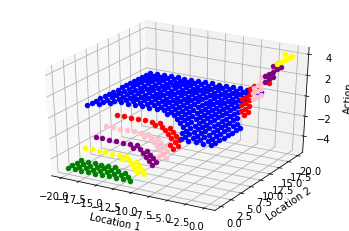

In [50]:
#i am not very good at matplot... negative location1 values is just to shift both axes to same origin -_-
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = ['blue','red','pink','purple','yellow','green']
for idx in range(len(X)):
    ax.scatter(-X[idx],Y[idx],ACTIONS[idx],c=colors[abs(ACTIONS[idx])])
ax.set_xlabel('Location 1')
ax.set_ylabel('Location 2')
ax.set_zlabel('Action')
plt.show()

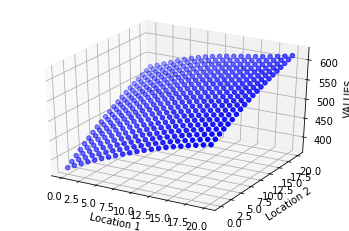

In [51]:
fig2 = plt.figure()
ax = fig2.add_subplot(111, projection='3d')
VALUES = df.StateValue.values
ax.scatter(X,Y,VALUES,c='blue')
ax.set_xlabel('Location 1')
ax.set_ylabel('Location 2')
ax.set_zlabel('VALUES')
plt.show()

In [52]:
time.time() - start_time

-147.08584022521973